In [4]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import itertools as it

np.random.seed(0)

sns.set(context='paper', style='ticks',
        font_scale=1, palette='colorblind')

## 1. Plotting the data

Let's start by generating the data. We will generate a random 8x20 binary matrix, where the probability of each element being 1 is 0.5:

In [5]:
# generate a random binary 8 by 20 matrix using binomial distribution
data = np.random.binomial(1, 0.4, (4, 8))

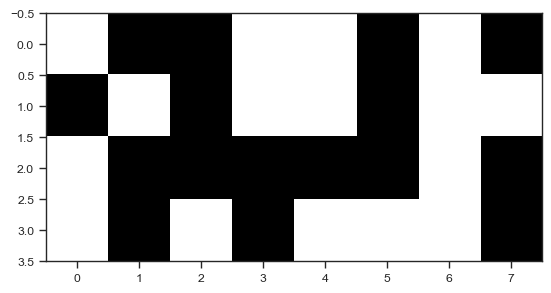

In [6]:
plt.imshow(data, cmap='Greys')

To visualize nestendess, we need to sort our matrix, so that the elements that are 1 are grouped together. We will sort both rows and columns by the number of 1s in each row and column, respectively.

In [7]:
def sort_matrix(M, iter):
    for _ in range(iter):
        # sort the matrix by the sum of each column 
        # (NB: reverse order, just for visuals)
        M = M[:, np.argsort(M.sum(axis=0))[::-1]]
        # sort the matrix by the sum of each row
        M = M[np.argsort(M.sum(axis=1))[::-1]]

    return M

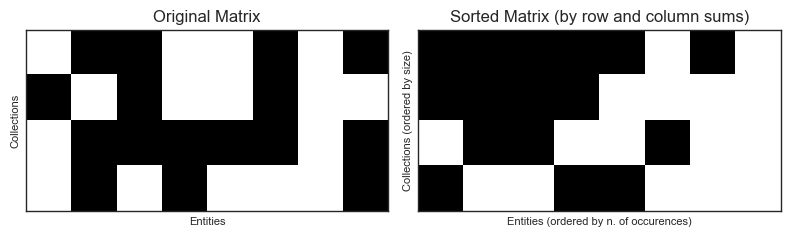

In [8]:
# plot original and sorted matrix with matplotlib

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].imshow(data, cmap='Greys', interpolation='nearest')
ax[0].set_title('Original Matrix', fontsize=12)
# remove ticks
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_ylabel('Collections', fontsize=8)
ax[0].set_xlabel('Entities', fontsize=8)

# apllying the sorting function
ax[1].imshow(sort_matrix(data, iter=10), cmap='Greys', interpolation='nearest')
ax[1].set_title('Sorted Matrix (by row and column sums)', fontsize=12)
# remove ticks
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_ylabel('Collections (ordered by size)', fontsize=8)
ax[1].set_xlabel('Entities (ordered by n. of occurences)', fontsize=8)

plt.tight_layout()
plt.show()

## 2. Generating the fully nested matrix


Another thing that interest us is the fully nested matrix given the same parameters. We will generate it by countin the number of items in each row, and then generating a new matrix, where eac row is filled from the start to n, where n is the number of 1s in the row.

In [9]:
def fully_nested_matrix(M):
    '''
    This function takes a binary matrix M and returns a fully nested matrix 
    of the same shape and fill per row.
    '''

    # count number of 1s in the rows
    row_counts = M.sum(axis=1)

    # generate fully nested matrix

    nested_matrix = np.zeros((M.shape[0], M.shape[1]))

    for i, j in enumerate(row_counts):
        nested_matrix[i, :j] = 1

    return nested_matrix

In [10]:
nested_matrix = fully_nested_matrix(sort_matrix(data, iter=100)) # NB: I am applying to the sorted matrix

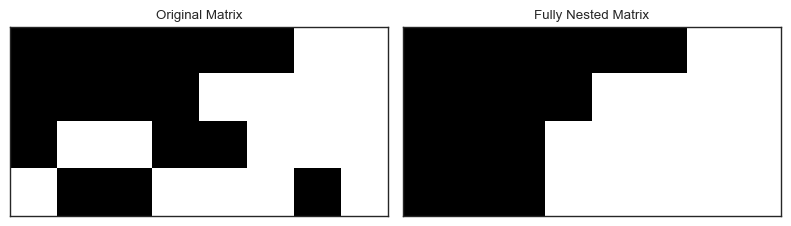

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].imshow(sort_matrix(data, iter=1), cmap='Greys', interpolation='nearest')
ax[0].set_title('Original Matrix')

ax[1].imshow(nested_matrix, cmap='Greys', interpolation='nearest')
ax[1].set_title('Fully Nested Matrix')

for a in ax:
    a.set_xticks([])
    a.set_yticks([])

plt.tight_layout()
plt.show()

## 3. NODF

In [12]:
def NODF(matrix):
    '''
    Compute the NODF metric for a given binary matrix.

    Returns
    -------

    NODF : float
        The NODF value of the matrix
    Fill : float
        The fill to size ratio of the matrix
    '''
    # Step 1: Convert each row into a set of column indices containing 1s
    row_idxs = [set(np.where(row == 1)[0]) for row in matrix]

    # Step 2: Generate all ordered pairs of row sets
    row_pairs = list(it.combinations(range(matrix.shape[0]), 2))

    # Step 3: Calculate the percentage overlap between each pair of rows
    Np_row = []
    for i, j in row_pairs:
        row_i = row_idxs[i]
        row_j = row_idxs[j]
        
        # Only calculate overlap if the number of 1s in row i is greater than or equal to row j
        if len(row_i) >= len(row_j) and len(row_j) > 0:
            overlap = 100 * len(row_i & row_j) / len(row_j)
            Np_row.append(overlap)

    # Step 4: Convert each column into a set of row indices containing 1s
    col_idxs = [set(np.where(col == 1)[0]) for col in matrix.T]

    # Step 5: Generate all ordered pairs of column sets
    col_pairs = list(it.combinations(range(matrix.shape[1]), 2))

    # Step 6: Calculate the percentage overlap between each pair of columns
    Np_col = []
    for i, j in col_pairs:
        col_i = col_idxs[i]
        col_j = col_idxs[j]
        
        # Only calculate overlap if the number of 1s in column i is greater than or equal to column j
        if len(col_i) >= len(col_j) and len(col_j) > 0:
            overlap = 100 * len(col_i & col_j) / len(col_j)
            Np_col.append(overlap)

    # Step 7: Calculate the NODF value as the average of row and column overlaps
    NODF = np.mean(Np_row + Np_col)
    return NODF, (matrix.sum() / matrix.size)


In [13]:
matrix = np.array([
    [1, 0, 1, 1, 1],  # r1
    [1, 1, 1, 0, 0],  # r2
    [0, 1, 1, 1, 0],  # r3
    [1, 1, 0, 0, 0],  # r4
    [1, 1, 0, 0, 0]   # r5
])

In [14]:
matrix.shape

(5, 5)

(np.float64(70.41666666666667), np.float64(0.56))


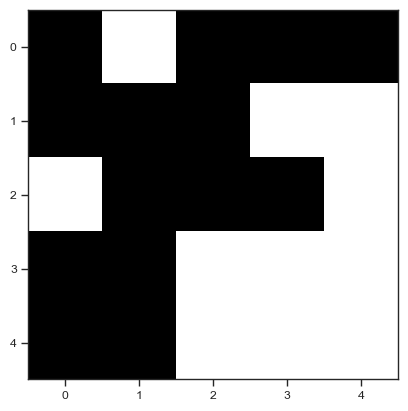

In [15]:
plt.imshow(matrix, cmap='Greys', interpolation='nearest')
print(NODF(matrix))

(np.float64(100.0), np.float64(0.56))


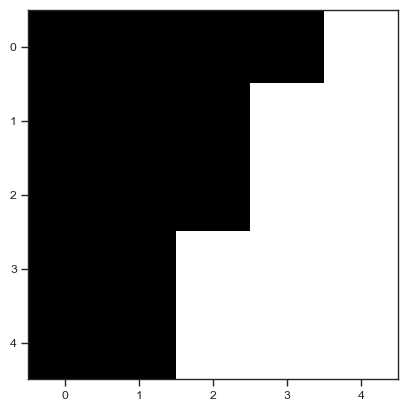

In [16]:
plt.imshow(fully_nested_matrix(matrix), cmap='Greys', interpolation='nearest')
print(NODF(fully_nested_matrix(matrix)))

## 4. Nestendess test

Generate 10.000 random binary matrices of the same size and fill and calculate the NODF metric for each one.

In [43]:
random_m = [NODF(np.random.binomial(1, (matrix.sum() / matrix.size), matrix.shape))[0] for _ in range(10000)]

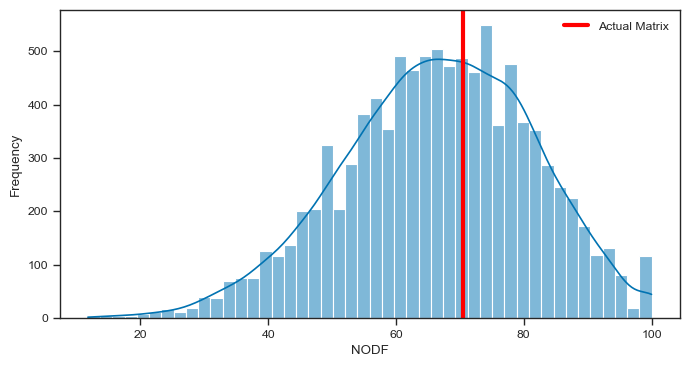

In [44]:
plt.figure(figsize=(8, 4))
sns.histplot(random_m, 
             kde=True,
             )
plt.axvline(NODF(matrix)[0], 
            color='red', 
            linewidth=3, 
            label='Actual Matrix')

plt.legend(frameon=False)
plt.xlabel('NODF')
plt.ylabel('Frequency')
plt.show()

In [45]:
print(f'P-value: {((np.sum(np.array(random_m) >= NODF(matrix)[0]) + 1) / (len(random_m) + 1)).round(3)}')

P-value: 0.417
